## File for locate bruise
##### Tresholds, og alt det der

In [1]:
import numpy as np
import spectral as sp
import matplotlib.pyplot as plt
import cv2
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from functions import *

In [11]:
names = np.array(["before-hit", "0m","30m","1h" ,"3h","12h", "24h", "48h"])

trainName = "3h"

strawberryCube = sp.open_image(getImage(trainName))
        
        # 0m: [420,5212,666] 30m: [465 ,5189, 666], 1h: [436,5304,666] , 3h: id2 [376, 5292,666],  
        
strawberryCoords = np.array([[376 ,5292, 666]])#
distinctBands = [75,106,175]                                   
strawberriesDistinct = strawberryCube.read_bands( distinctBands ) # Only distinct bandsareaBruised

Training data bruised spectrums: 18091
Training data healthy spectrums: 198601
X_train shape: (216692, 3)
y_train shape: (216692,)


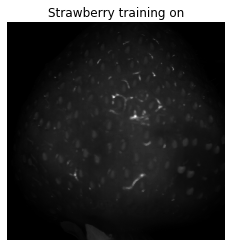

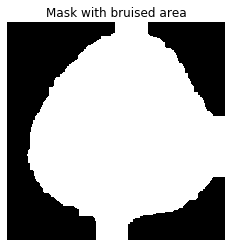

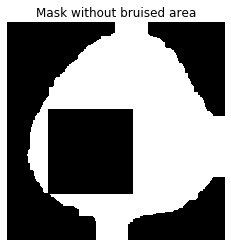

In [12]:
strawberries = []  # List of whole strawberries
for coord in strawberryCoords:
    strawberries.append(getRegion(strawberriesDistinct, coord[0], coord[1], coord[2]))

strawberries = np.array(strawberries)

for strawberry in strawberries:    
    sp.imshow(strawberry[:,:,strawberry[-1].shape[-1]-1], title="Strawberry training on")
    plt.axis('off')



    # center of bruised area with given radius on different strawberries, index 3 is the radius
                            # id 1             # id 7
bruises     = np.array([[255, 395, 200]])#, [500,500,200]]) #[470, 410, 200], [220, 340, 200]]), 3h: id2[250, 375], id8, [300,350, 200]
bruisetrain = np.array([[225, 395, 150]])#, [500,500,100]]) # [470, 410, 70], [220, 340, 30]]) 



X_train = []
y_train = []

for i in range(len(bruisetrain)):

    areaBruised = getRegion(strawberries[i], bruisetrain[i][0], bruisetrain[i][1], bruisetrain[i][2]) # subimage of a bruised area
    noSeeds = removeSeeds(areaBruised)
    n,bands = noSeeds.shape
    X_train.extend(noSeeds)
    print("Training data bruised spectrums: %d" % (n))
    y_train.extend(np.ones(n))
    
    
    # removes the bruised part on the whole strawberry
for i in range(len(strawberries)):
    mask = strawberryMask(strawberries[i])
    sp.imshow(mask, title="Mask with bruised area")
    plt.axis('off')
    strawberries[i][bruises[i][1] - bruises[i][2]//2 : bruises[i][1] + bruises[i][2]//2 , 
                    bruises[i][0] - bruises[i][2]//2 : bruises[i][0] + bruises[i][2]//2] = 0



for strawberry in strawberries:
    
    mask = strawberryMask(strawberry)
    sp.imshow(mask, title="Mask without bruised area")
    plt.axis('off')
    values = strawberry[np.where(mask==1)]
    n,bands = values.shape
    
    X_train.extend(values)
    y_train.extend(np.zeros(n))
    
    print("Training data healthy spectrums: %d" %(n))


X_train = np.array(X_train)


X_train = np.array(X_train)
y_train = np.array(y_train)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

In [13]:
from joblib import dump, load

svm = svm.SVC() 
svm.fit(X_train, y_train)
print("SVM trained")

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print("KNN trained")

 # Saving model for later use 

nr = "2" # strawberry id used for training
fileNameSVM = "SVM_" + trainName + "_STB" + nr + ".joblib"
fileNameKNN = "KNN_" + trainName + "_STB" + nr + ".joblib"
#dump(svm, fileNameSVM)   # save models
#dump(knn, fileNameKNN) 

SVM trained
KNN trained


Data reduced by not including zeros: 0.673739


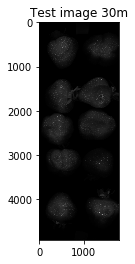

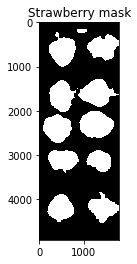

In [14]:
testName = "30m"

strawberryCube = sp.open_image(getImage(testName))
strawberriesDistinct = strawberryCube.read_bands( distinctBands )[1000:,:,:] # Only distinct bands and removes the reference obj.

                                             #12h    # berry 1             berry 2          berry 3       berry 1,2,3,4      berry 7,8,9,10
#testimg = getRegion(strawberriesDistinct, 900, 4504, 1800)  #[1224, 5090, 600], [333 ,5060, 666] , [344, 3912] , [900, 4504, 1800], [900, 1960, 1800]
testimg = strawberriesDistinct
sp.imshow(testimg[:,:,testimg.shape[-1]-1], title="Test image " + testName)

mask = strawberryMask(testimg)
sp.imshow(mask, title="Strawberry mask")

x_test = testimg[np.where(mask==1)]

print("Data reduced by not including zeros: %f" % ( 1-np.prod(x_test.shape)/np.prod(testimg.shape) ) )



SVM starting prediction
KNN starting prediction


<bound method ImageView.show_data of ImageView object:
  Display bands       :  [0]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 2.023667335510254]
    G: [0.0, 2.023667335510254]
    B: [0.0, 2.023667335510254]
>

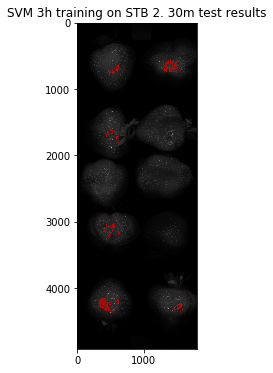

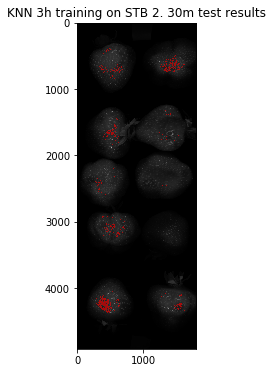

In [15]:

svm = load("SVM_0m_STB2.joblib") # for loading trained models
knn = load("KNN_0m_STB2.joblib") 

print("SVM starting prediction")
predSVM = svm.predict(x_test)
predKNN = knn.predict(x_test)

predictionSVM = mask.copy()
predictionSVM[predictionSVM == 1] = predSVM

print("KNN starting prediction")
predictionKNN = mask.copy()
predictionKNN[predictionKNN == 1] = predKNN


viewSVM = sp.imshow(testimg[:,:,testimg.shape[-1]-1], figsize=(6,6), title="SVM "+trainName+" training on STB 2. "+testName+" test results")
viewSVM.set_classes(predictionSVM)
viewSVM.set_display_mode('overlay')
viewSVM.class_alpha = 0.6 #set transparency
viewSVM.show_data
 
viewKNN = sp.imshow(testimg[:,:,testimg.shape[-1]-1], figsize=(6,6), title="KNN "+trainName+" training on STB 2. "+testName+" test results")
viewKNN.set_classes(predictionKNN)
viewKNN.set_display_mode('overlay')
viewKNN.class_alpha = 0.6 #set transparency
viewKNN.show_data